# By The Numbers - My Time At UWaterloo

To commemorate my recent graduation from the University of Waterloo, like most grads, I decided to take a look back. However, I decided to try something a bit different. Seeing as I graduated with a degree in Computer Engineering, I decided to throw some code and data analysis into the mix, to really see what I learned over the past few years.

I started by gathering roughly a gigabyte of data from all the online services I've used over the years - banks, Google, Netflix and even from the University of Waterloo - my emails, transcripts and various other academic records.

I dumped all this into a database, wrote some code and came up with some interesting graphs. Without further ado, let's take a look at what I found.

One quick note: this analysis is not particularly rigorous, nor am I making any claims about causation. I'm going to show some interesting correlations and try to explain, to the best of my ability, why they occurred.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%load_ext sql
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=1
%sql mysql://root@localhost/finale
    

%matplotlib inline
sns.set_style("ticks")

## Fun Facts

Lets look at some quick facts to get started.

In [2]:
%sql SELECT sum(academic_hours) from academics_class_hours;

1 rows affected.


,sum(academic_hours)
0,2415.083333


In [3]:
%sql SELECT count(distinct(course)) from transcript;

1 rows affected.


,count(distinct(course))
0,52


In [4]:
%sql df << SELECT * from important_dates;

22 rows affected.
Returning data to local variable df


In [5]:
df = df.replace({'period' : {'exam':'academic', 'class': 'academic'}})
total_days = (df.end.max() - df.start.min()).days
total_days

1688

In [6]:
df2 = df.groupby(['term', 'period']).start.min().reset_index()
df2['end'] = df.groupby(['term', 'period']).end.max().reset_index().end
df2['duration'] = df2.end-df2.start
df2['duration'] = df2.duration.apply(lambda x: x.days)
df2 = df2.groupby('period').sum().reset_index()
df2.loc[2] = ['off', (df.end.max() - df.start.min()).days - df2.duration.sum()]  # adding a row
df2

,period,duration
0,academic,846
1,coop,661
2,off,181


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


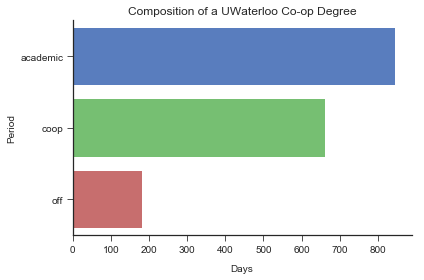

In [7]:
sns.set_palette(sns.color_palette("muted"))

ax = sns.barplot(x='duration', y='period', data=df2)
sns.despine()
ax.xaxis.labelpad = 10
ax.set_title('Composition of a UWaterloo Co-op Degree')
ax.set(xlabel='Days', ylabel='Period')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/academics_day_breakdown.svg', transparent=True)

### Time At Waterloo
Over the course of my degree at the University of Waterloo, I've had 8 academic terms and 6 co-op terms. That's a grand total of 1688 days, which is approximately 4.5 years.

A common misconception at Waterloo is the idea you have no days off - you're either studying or on a co-op term. The data, however, tells a different story. While I did spent most of my time working, I did have approximately 40 days a year off. Not too bad and it's definitely more than you get in the real world.

## Academics

In [8]:
%%sql
df << select * from academics_class_hours

9 rows affected.
Returning data to local variable df


In [9]:
df['class_hours'] = df.class_hours / (df.length_days / 7)
df['tut_hours'] = df.tut_hours / (df.length_days / 7)
df['lab_hours'] = df.lab_hours / (df.length_days / 7)

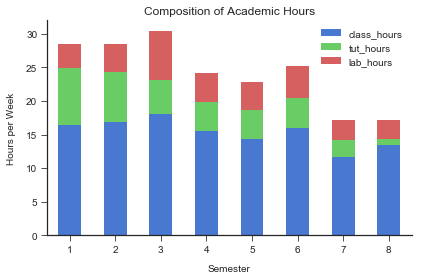

In [10]:
df = df[df.semester.notnull()]
df['semester'] = df.semester.astype(int)
ax = df[['semester', 'class_hours', 'tut_hours', 'lab_hours']].set_index('semester').plot(kind='bar', stacked=True)
ax.tick_params(axis='x', rotation=0)
sns.despine()
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.set_title('Composition of Academic Hours')
ax.set(xlabel='Semester', ylabel='Hours per Week')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/academics_hour_breakdown.svg', transparent=True)

### Workload
To fulfill my degree requirements, I took 52 courses which amounted to 2415 hours of scheduled class time.

Average academic hours peaked at 30 hours/week during the notorious ECE 2A, after which they have generally decreased. The composition of academic hours has roughly stayed the same throughout my undergrad career, with the exception of tutorials becoming less significant in my upper years.

In [11]:
%%sql
df << select * from academics_transcript_summary

8 rows affected.
Returning data to local variable df


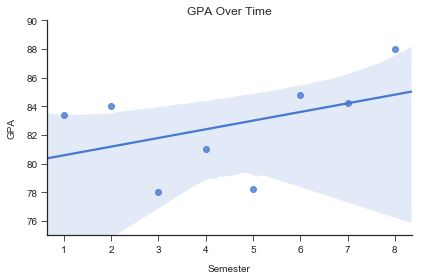

In [12]:
df['semester'] = [1, 2, 3, 4, 5, 6, 7, 8]
ax = sns.regplot(x='semester', y='gpa', data=df)
ax.set(ylim=(75, 90))

sns.despine()
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.set_title('GPA Over Time')
ax.set(xlabel='Semester', ylabel='GPA')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/academics_gpa_vs_semester.svg', transparent=True)

### GPA
My GPA has fluctuated, but generally trended upward towards the end of my degree. I suspect this is due to a few things, including getting acclimatized the the university experience and the variety of interesting technical courses in the upper years. Of course, some of the easier electives (https://alobo.github.io/electives/) certainly helped.

### Attendance

Did you know that the Timeline feature on Google Maps tracks your location? I exported my data from Google and was surprised to find GPS coordinates recorded every few minutes, from the past five years. I knew Google was tracking this, but I was surprised at the accuracy and quantity of information. 

Kinda scary, but this data is also useful for what I'm doing here.

In [13]:
%%sql
df << select * from location_aggregate_event_attendance

8 rows affected.
Returning data to local variable df


In [14]:
df = df[df.semester.notnull()]
df['attendance'] = pd.to_numeric(df['attendance'])

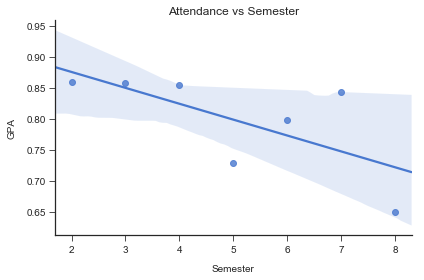

In [15]:
ax = sns.regplot(x='semester', y='attendance', data=df)
sns.despine()
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.set_title('Attendance vs Semester')
ax.set(xlabel='Semester', ylabel='GPA')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/academics_attendance_vs_semester.svg', transparent=True)

Attendance has been on a general decline since I started (with the exception of some classes with mandatory attendance skewing the numbers).

In [16]:
%%sql
df << SELECT (DAYOFWEEK(start)) as day, present FROM event_attendance;

1518 rows affected.
Returning data to local variable df


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


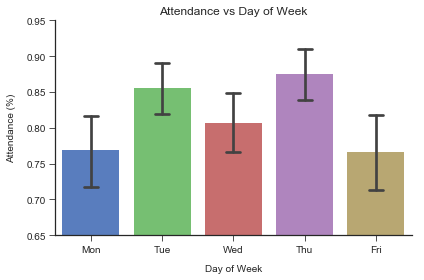

In [17]:
df = df.replace({'day': {1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'}})
ax = sns.barplot(x='day', y='present', data=df, capsize=.2)
ax.set(ylim=(0.65, 0.95))

sns.despine()
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.set_title('Attendance vs Day of Week')
ax.set(xlabel='Day of Week', ylabel='Attendance (%)')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/academics_attendance_vs_day_of_week.svg', transparent=True)

My class attendance varied across the week, but most noticeably dropped off on Mondays and Fridays 🤔

## Coffee

It's no secret - coffee is partially responsible for getting me through my university career. Seeing as I made the most of my coffee purchases with either my credit card or my Waterloo student card, I was able to pull all the records and extract some insights.

I was able to sum up how much I had spent at Tim Hortons, Starbucks and various other coffee shops over the past five years. And unfortuantely that number is slightly depressing.

So lets talk about something more fun:

In [18]:
%%sql
df << SELECT term, semester, coffee_spend * -1 as coffee_spend, coffee_events FROM finance_coffee_spend

13 rows affected.
Returning data to local variable df


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Coffees Purchased Over my Undergrad Degree')

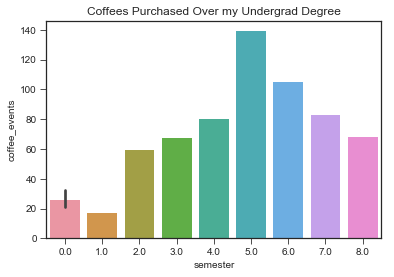

In [19]:
ax = sns.barplot(x='semester', y='coffee_events', data=df, label='test')
ax.set_title('Coffees Purchased Over my Undergrad Degree')

In [20]:
%%sql
df << SELECT (DAYOFWEEK(date)) as day, amount * -1 as coffee_spend FROM finances WHERE category LIKE "%coffee%"

764 rows affected.
Returning data to local variable df


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


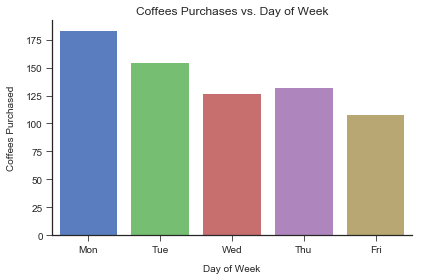

In [21]:
df = df[(df.day != 1) & (df.day != 7)]
df = df.sort_values('day')
df = df.replace({'day': {1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'}})
ax = sns.countplot(x='day', data=df)

sns.despine()
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.set_title('Coffees Purchases vs. Day of Week')
ax.set(xlabel='Day of Week', ylabel='Coffees Purchased')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/coffee_vs_day_of_week.svg', transparent=True)
# # ax.set(ylim=(3, 6.5))

Calculate the extra coffee spend on Mondays compared to the rest of the work week

In [22]:
avg = df[(df.day != 'Sat') & (df.day != 'Sun')].groupby('day').count().mean().coffee_spend
mon = df[df.day == 'Mon'].groupby('day').count().mean().coffee_spend
((mon - avg) / avg) * 100

30.156472261735424

# Co-Op


In [23]:
%%sql
df << SELECT * FROM academics_coop_interviews

8 rows affected.
Returning data to local variable df


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


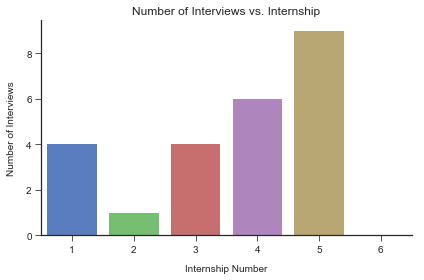

In [24]:
# Only care about 6 co-op terms
df = df[df.semester <= 6]

ax = sns.barplot(x='semester', y='interviews', data=df)
sns.despine()
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.set_title('Number of Interviews vs. Internship')
ax.set(xlabel='Internship Number', ylabel='Number of Interviews')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/coop_interviews_vs_internship.svg', transparent=True)
# # ax.set(ylim=(3, 6.5))

## Netflix!

In [25]:
%%sql
df << SELECT * FROM  media_consumption

15 rows affected.
Returning data to local variable df


In [26]:
df.head()

,term,semester,hours_watched,movie_count,shows_count,average_runtime
0,None,NaN,119.316667,5,165,0.674105
1,1A,1.0,40.600000,6,70,0.534211
2,1B,2.0,58.266667,10,72,0.710569
3,2A,3.0,28.250000,1,71,0.392361
4,2B,4.0,34.000000,2,65,0.507463


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


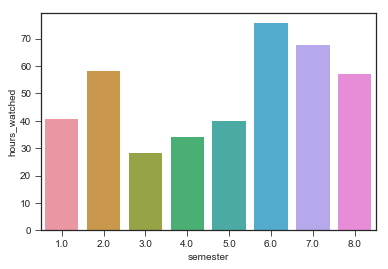

In [27]:
ax = sns.barplot(x='semester', y='hours_watched', data=df[df.semester > 0], label='test')
# ax.set_title('Coffees Purchased Over my Undergrad Degree')

In [28]:
%%sql
df << SELECT (DAYOFWEEK(date)) as day, runtime FROM media

1306 rows affected.
Returning data to local variable df


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[(150, 225)]

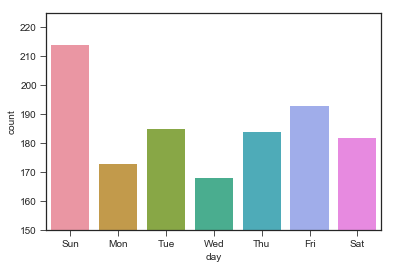

In [29]:
df = df.sort_values('day')
df = df.replace({'day': {1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'}})
# ax = sns.pointplot(x='day', y='coffee_spend', data=df, capsize=.2)
ax = sns.countplot(x='day', data=df)
# ax.set_title('Coffees Purchases vs. Day of Week')
ax.set(ylim=(150, 225))

# Big Picture

The last thing left to do was look at correlations.

In [30]:
%%sql
df << SELECT * FROM academics_transcript_summary
    LEFT JOIN academics_coop_interviews USING(term)
    LEFT JOIN academics_class_hours USING(term, semester)
    LEFT JOIN finance_coffee_spend USING(term, semester)
    LEFT JOIN location_aggregate_event_attendance USING(term, semester)
    LEFT JOIN location_home_visits USING(term, semester)
    LEFT JOIN media_consumption USING(term, semester);

8 rows affected.
Returning data to local variable df


In [31]:
df = df.drop(columns=['term'])
df = df.drop(columns=['movie_count', 'shows_count', 'average_runtime', 'coffee_spend'])

df['interviews'] = pd.to_numeric(df.interviews)
df['attendance'] = pd.to_numeric(df.attendance)
df['days_at_home'] = pd.to_numeric(df.days_at_home)

df

,semester,gpa,interviews,academic_hours,class_hours,avg_lec_len,tut_hours,lab_hours,length_days,coffee_events,attendance,days_at_home,hours_watched
0,1,83.4,4.0,342.416667,197.750000,0.886771,100.666667,44.000000,84,17,NaN,0.0,40.600000
1,2,84.0,1.0,350.166667,207.833333,0.884397,91.333333,51.000000,86,59,0.8599,7.0,58.266667
2,3,78.0,4.0,396.166667,235.000000,0.833333,65.833333,95.333333,91,67,0.8579,11.0,28.250000
3,4,81.0,6.0,294.000000,189.500000,1.343972,50.666667,53.833333,85,80,0.8537,16.0,34.000000
4,5,78.2,9.0,277.833333,173.333333,1.171171,52.833333,51.666667,85,139,0.7286,13.0,40.083333
5,6,84.8,0.0,324.500000,206.333333,1.339827,56.333333,61.833333,90,105,0.7977,12.0,75.616667
6,7,84.2,0.0,209.000000,142.166667,1.137333,30.000000,36.833333,85,83,0.8430,17.0,67.583333
7,8,88.0,0.0,220.166667,173.333333,1.333333,10.833333,36.000000,90,68,0.6500,17.0,57.216667


In [ ]:
corr = df.corr()
plt.subplots(figsize=(7,6))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.diverging_palette(220, 10, sep=150, n=9))
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/correlation_matrix.svg', transparent=True)

## Curious Correlations

### Netflix & GPA

In [ ]:
ax = sns.regplot(x='gpa', y='hours_watched', data=df)

sns.despine()
ax.xaxis.labelpad = 10
ax.set_title('Hours of Netflix Watched vs. GPA')
ax.set(xlabel='GPA', ylabel='Netflix Watched (hours)')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/correlation_netflix_gpa.svg', transparent=True)

### Coffee & GPA
My coffee spend had a mild negative correlation with GPA - more coffees purchased were associated with lower GPAs.

In [ ]:
ax = sns.regplot(x='coffee_events', y='gpa', data=df)
sns.despine()

ax.xaxis.labelpad = 10
ax.set_title('Coffees Purchased vs. GPA')
ax.set(xlabel='GPA', ylabel='Coffees Purchased')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/correlation_coffee_gpa.svg', transparent=True)

### Class Hours
Hours spent in class had a mild negative correlation with GPA - semesters with greater time in class were associated with lower GPAs.

In [ ]:
sns.regplot(x='class_hours', y='gpa', data=df)

### Interviews & GPA
Possibly the most interesting correlation - the number of interviews in a term had a strong negative correlation with my GPA. This is understandable though, as co-op interviews occur around midterm season and usually end up conflicting with lectures.

Current and future Waterloo students - note that this is the tradeoff with the co-op schedule.

In [ ]:
ax = sns.regplot(x='interviews', y='gpa', data=df)
sns.despine()
ax.xaxis.labelpad = 10
ax.set_title('Co-op Interviews vs. GPA')
ax.set(xlabel='Co-op Interviews', ylabel='GPA')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/correlation_gpa_interviews.svg', transparent=True)

## Takeaways

In [ ]:
df2 = df[['semester', 'gpa', 'interviews', 'coffee_events', 'hours_watched']]
df2.columns = ['semester', 'gpa', 'interviews', 'coffee_purchases', 'netflix_hours_watched']
df2 = df2.set_index('semester')
df2=(df2-df2.min())/(df2.max()-df2.min())
df2=(df2-df2.mean())/df2.std()

ax = df2.plot()
ax.axvline(x=5, color='black', linestyle='dotted')
sns.despine()

ax.xaxis.labelpad = 10
ax.set_title('The Big Picture')
ax.set(xlabel='Semester', ylabel='Mean Normalized Value')
ax.get_figure().tight_layout()
ax.get_figure().savefig('export/the_big_picture.svg', transparent=True)

There was a lot more to my university experience that this graph, nor any data, does not capture - the adventures I had, the friends I met and the memories I made.

However if I could plot my stress levels, they would look a lot like this graph - they'd start low, peak at semester 5 and drop off afterwards. Semester 5 was an inflection point, representing peak caffeine consumption, a low GPA and tons of hours sunk into interview prep. However it was also where I figured out how the whole university thing worked.

And that's my takeaway - to future and current students, Waterloo or otherwise, you will figure things out. You will figure out how you study effectively, how to land interviews and how to schedule everything so you have some free time. Things get better; trust the process.

Sure, I recognize all of this is with a sample size of one. But just looking at my classmates and friends, I am confident that the majority fit the same profile.

# Thank You!

Thanks for taking the time to read this! This project was the results of many hours of work doing what I'm quite passionate about - wrangling and visualizing data.


## Methadology
This code for this project was structured as a simple ETL (Extract-Transfer-Load) Data Pipeline. It processed my data and loaded it into a SQL database, after which I queried it and generated these graphs.

Analysis and visualization were performed using several of my facourite Python Data Science tools, including: Jupyter Notebook, pandas, matplotlib and seaborn.
You can check out the source code on [GitHub](https://github.com/alobo/by-the-numbers).


## Inspirations
* https://classprofile.andyzhang.net/
* http://joeyloi.com/SYDE2017classprofile.pdf